最近在阅读  这本书，其中第二章使用一个完整的例子来说明机器学习解决问题的主要过程。
笔者实现了全部，打算做个回顾。

这是一个 房价预测项目，和kaggle的入门例子略有不同，主要分为以下几个步骤：
1. 总览
2. 获取数据
3. 探索和可视化数据
4. 准备可用于机器学习算法的数据
5. 选择一个模型并训练
6. 微调该模型
7. 演示解决方案
8. 启动，监视和维护该系统

**学习机器学习最好的就是使用真实数据，而不仅仅是人造数据**  
本次数据是 1990年加利福尼亚州人口调查的房价数据，但非常适合作为数据集，其中也有类别数据，文章作者也提到为了教学使用，也移除了部分特征。
![%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-18%2023.56.46.png](attachment:%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-18%2023.56.46.png) 
上图就是不同区房价的分布图，涉及经纬度， 人口的分布和预测的结果：房价的中位数。
根据训练数据得到的模型，给定其余数据，应该能测去相应区的房价。

## 总览问题
在开始设计机器学习的系统之前，需要对问题有初步了解，监督， 非监督，还是强化学习？分类，回归还是其他？是批量学习还是在线学习等等？
本题有给定结果类别，是一个监督的回归问题。

#### 选择性能测量方法

对于回归问题，一般采用均方根误差(Root Mean Square Error (RMSE)), 也叫标准误差。
![%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-19%2000.53.48.png](attachment:%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-19%2000.53.48.png)
这是计算方法，公式中的参数不过过多解释，相信都能看懂。
该值反映了预测值的精确度。假设该值为50000，由于误差满足正态分布，因此有68%的概率，真实值和预测值的误差在50000之间，95%的概率在100000之间。

当然还有平均绝对误差：
![%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-19%2000.58.48.png](attachment:%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-19%2000.58.48.png)
上面两种方法都是两个向量之间的差异.还有许多的测量方法，这里直接贴一段原文：
其中的概念可以了解一下，l1, l2,ln范数。
![%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-19%2001.05.24.png](attachment:%E5%B1%8F%E5%B9%95%E5%BF%AB%E7%85%A7%202018-04-19%2001.05.24.png)
范数指数越高，对较大值越敏感，越忽略极小值。这一段不理解没有关系，往后继续。




### 准备工作
这里假设已经安装了python等开发工具，强烈推荐anaconda，使用jupyter进行代码实现。


首先导入基本的数据处理以及可视化库

In [6]:
# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
# 可视化的设置：图例，x，y轴的字体大小
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [8]:
# 图片存储目录
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


warnings.filterwarnings(action='ignore', module='scipy', message='internal gelsd')

### 获取数据
在目录 `datasets` 下可以找到所需要的数据

In [9]:
# 加载数据
HOUSING_PATH = os.path.join("datasets", "housing")
def loading_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

首先看一下数据集的大体结构(pd.head(n)表示查看前n个特征， 默认为5)

In [10]:
housing = loading_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


如上，可以看到每个特征共有10个属性，该特征包括经纬度，房子平均年龄，房间总数，卧室总数， 人口数，家庭数，收入,房屋价格(label),与海洋的距离等，不同的属性对结果的权重不同，需要后面进行判断。  

In [11]:
# info 对数据类型，是否为空进行描述
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


可以看到该数据集一共有 20640 个特征，10个属性。其中前9个都是数值类型的特征， 最后一个 ocean_promixity不是数值，需要额外处理。
比较重要的是，卧室总数共计 20433 非空特征，因此这个特征包括空值。对于机器学习算法来说，空值影响巨大，因此需要额外处理，后续介绍。

In [12]:
# ocean_promixity 是object，不过既然是从csv文件中读取，那么说明是文本，一般是类别数据。
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

`value_counts()`函数可以进行统计，可以看到该属性共计5个类别，包括类别名称这占比。

使用decribe()可以查看数值属性的几个重要信息

In [13]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


如上，列出了9个数值属性的一些数据，包括count属性，平均值， 方差(数据的离散程度)，最小值，最大值。
其中25%， 50%， 75%表示数据分布，比如 housing_median_age 这一项，表示25%的特征在该属性在18以下， 50%在29以下，75%在37以下。

当然，出了上述简单分析，还可以对数据进行可视化查看，如下：

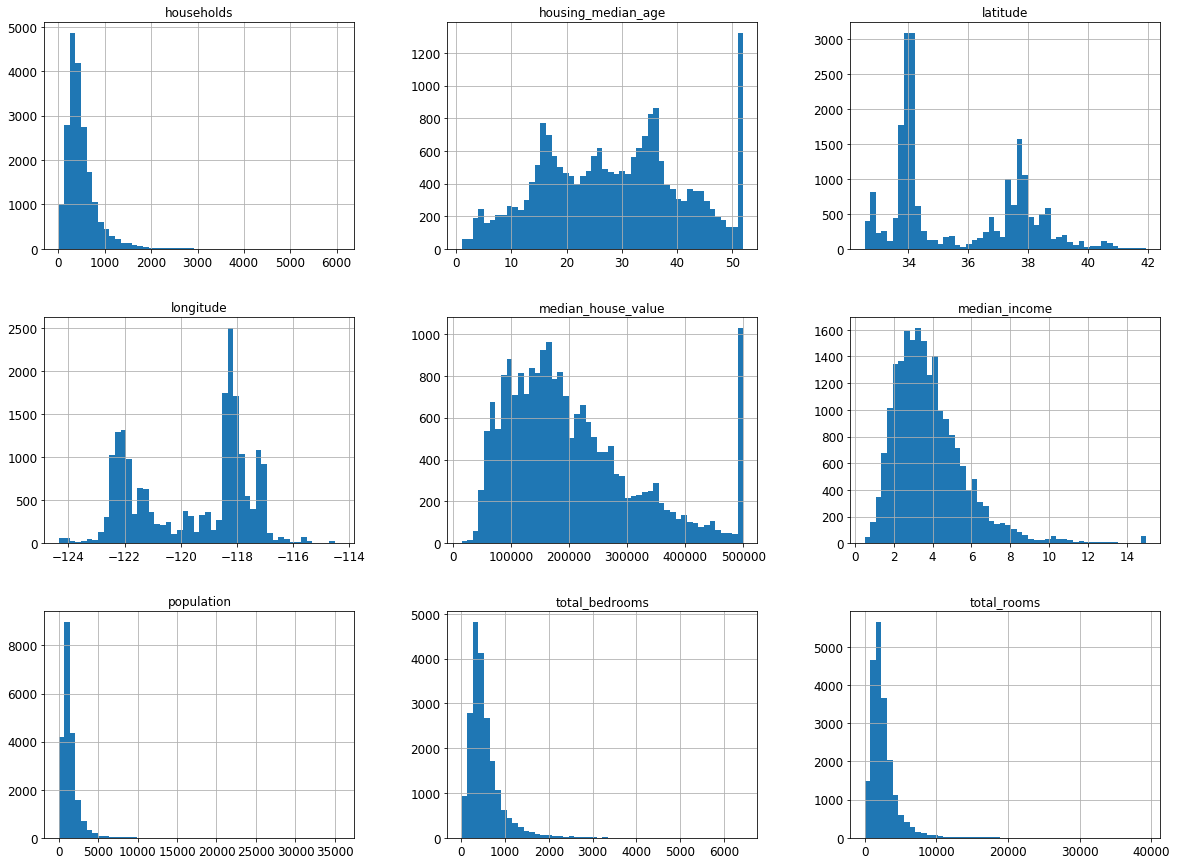

In [14]:
%matplotlib inline
housing.hist(bins=50, figsize=(20, 15))
plt.show()

如上，列出了9个数值属性的大概分布情况。pd.hist()函数是直方图可视化函数，默认bins为10等分，题图为50等分，figsize表示图像大小，英寸为单位。

从直方图中大概可以获取一下几点信息：
1. median income 这一项不像是用USD 表示，0.49999---15范围之间。因此该属性经过特征缩放，在机器学习中非常常见，知道数据怎么进行特征缩放。
2. housing median age 和 median hosuing value 也经过了处理。后面一项要特别注意，因为是预测的数据。
3. 这些特征都进行了特征缩放，后面会进行讨论。
4. 部分属性的尾部数据较重， 致使中位数更向右偏移。对机器学习算法预测来说会更加困难。后面会对这种情况进行转换。

### 获取测试数据
随机选取部分数据作为测试数据，作为算法精确度的验证

In [19]:
# 随机因子，保持每次产生的随机数一样
np.random.seed(42)

In [20]:
# 图例使用，sklearn有更方便的函数：train_test_split()
def split_train_test(data, test_radio):
    shuffed_indices = np.random.permutation(len(data)) # 返回打乱后的数组
    test_set_size = int(len(data) * test_radio)
    test_indices = shuffed_indices[:test_set_size]
    train_indices = shuffed_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [21]:

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "trian + ", len(test_set), " test")

16512 trian +  4128  test


如上，可以看到随机将数据集的20%， 4000个特征用作测试数据。

In [24]:
# 后续将使用sklearn的数据切分方法：
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


先来看一下 median income特征

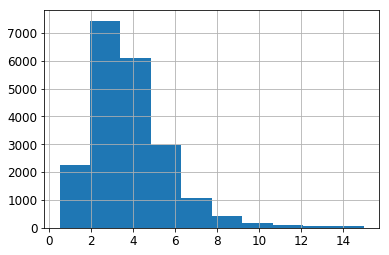

In [28]:
housing['median_income'].hist()

可以看到，大部分收入在2-5之间，少部分大于6。对于数据集来说，假设数据集的人员告诉你，对于房价来说，收入水平是一个非常重要的因素，
需要确保测试集是整个数据集中各种收入类别的代表。因此接下来对输入大概分个类别。

In [55]:
# 在数据集中添加一列，属性为income_cat
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].value_counts()
# housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

3.0     7236
2.0     6581
4.0     3639
5.0     1423
1.0      822
6.0      532
7.0      189
8.0      105
9.0       50
11.0      49
10.0      14
Name: income_cat, dtype: int64

这里将收入 除以1.5，减少类别。可以看到5以上的数据较少，可以合并为5.如下：



In [56]:
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

上面提到，保持测试集中的数据类别和训练集一样非常重要。可用以下算法进行随机抽样，形成测试集。


In [57]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

对数据集中 income_cat 中各类别数据进行统计：

In [60]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [61]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

可以看到两个数据集中不同类别出现的数据占比相同。可以用如下方法对比下一随机抽样和分层抽样与数据集的差异。

In [63]:
# 分层抽样和随机抽样 对测试集的区别

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [64]:
compare_props  # 可以看到分层抽样集中的数据结构和数据集的基本一致，随机划分的就差很多

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011
